# Music Recommender System using ALS Algorithm with Apache Spark and Python
+ **Estimated Execution Time (whole script): 2 minutes**
+ **Estimated Time (to complete the project): 8 hours**

## Description

For this project, you are to create a recommender system that will recommend new musical artists to a user based on their listening history. Suggesting different songs or musical artists to a user is important to many music streaming services, such as Pandora and Spotify. In addition, this type of recommender system could also be used as a means of suggesting TV shows or movies to a user (e.g., Netflix). 

To create this system you will be using Spark and the collaborative filtering technique. The instructions for completing this project will be laid out entirely in this file. You will have to implement any missing code as well as answer any questions.

**Submission Instructions:** 
* Add all of your updates to this Jupyter Notebook file and do NOT clear any of the output you get from running your code.
* Upload this file and the genererated HTML onto Moodle as a single zip folder called with your user name.

## Datasets

You will be using some publicly available song data from audioscrobbler, which can be found [here](http://www-etud.iro.umontreal.ca/~bergstrj/audioscrobbler_data.html). However, we modified the original data files so that the code will run in a reasonable time on a single machine. The reduced data files have been suffixed with `_small.txt` and contains only the information relevant to the top 50 most prolific users (highest artist play counts).

The original data file `user_artist_data.txt` contained about 141,000 unique users, and 1.6 million unique artists. About 24.2 million users’ plays of artists are recorded, along with their count.

Note that when plays are scribbled, the client application submits the name of the artist being played. This name could be misspelled or nonstandard, and this may only be detected later. For example, "The Smiths", "Smiths, The", and "the smiths" may appear as distinct artist IDs in the data set, even though they clearly refer to the same artist. So, the data set includes `artist_alias.txt`, which maps artist IDs that are known misspellings or variants to the canonical ID of that artist.

The `artist_data.txt` file then provides a map from the canonical artist ID to the name of the artist.

In [1]:
# Import libraries
import findspark
findspark.init()

from pyspark.mllib.recommendation import *
import random
from operator import *
from collections import defaultdict

def rep(x):
    aid  = x[1]
    for key, val in artistAliasDict:
        if key == x[1]:
            aid = val
    return (x[0], aid, x[2])

In [2]:
# Initialize Spark Context
# YOUR CODE GOES HERE
from pyspark import SparkContext
sc =SparkContext()

## Loading data

Load the three datasets into RDDs and name them `artistData`, `artistAlias`, and `userArtistData`. View the README, or the files themselves, to see how this data is formated. Some of the files have tab delimeters while some have space delimiters. Make sure that your `userArtistData` RDD contains only the canonical artist IDs.

In [3]:
# Import test files from location into RDD variables
# YOUR CODE GOES HERE
artistData = sc.textFile("data_raw/artist_data_small.txt").map(lambda x: x.split("\t"))
artistAlias = sc.textFile("data_raw/artist_alias_small.txt").map(lambda x: x.split("\t"))
userArtistData = sc.textFile("data_raw/user_artist_data_small.txt").map(lambda x: x.split(" "))

# Split a sequence into seperate entities and store as int
# YOUR CODE GOES HERE

artistData = artistData.map(lambda x:(int(x[0]),x[1]))
artistAlias = artistAlias.map(lambda x:(int(x[0]),int(x[1])))
userArtistData = userArtistData.map(lambda x: (int(x[0]), int(x[1]), int(x[2])))

# Create a dictionary of the 'artistAlias' dataset
# YOUR CODE GOES HERE

artistAliasDict = {}
a = artistAlias.collect()
for k, v in a:
    artistAliasDict[int(k)]=int(v)

# If artistid exists, replace with artistsid from artistAlias, else retain original
# YOUR CODE GOES HERE

def rep(a):
    if a[1] in artistAliasDict.keys():
        return (a[0],artistAliasDict[a[1]],a[2])
    else:
        return (a[0],a[1],a[2])
            
userArtistData = userArtistData.map(lambda x: (x[0], x[1], x[2])).map(rep)



## Data Exploration

In the blank below, write some code that with find the users' total play counts. Find the three users with the highest number of total play counts (sum of all counters) and print the user ID, the total play count, and the mean play count (average number of times a user played an artist). Your output should look as follows:
```
User 1059637 has a total play count of 674412 and a mean play count of 1878.
User 2064012 has a total play count of 548427 and a mean play count of 9455.
User 2069337 has a total play count of 393515 and a mean play count of 1519.
```



In [4]:
# Create an RDD consisting of 'userid' and 'playcount' objects of original tuple
# YOUR CODE GOES HERE

c = userArtistData.map(lambda x: (x[0], x[2]))
# Count instances by key and store in broadcast variable
# YOUR CODE GOES HERE

counts = c.groupByKey().map(lambda x: (x[0], sum(x[1]), sum(x[1])/len(list(x[1]))))



# Compute and display users with the highest playcount along with their mean playcount across artists
# YOUR CODE GOES HERE

top3= counts.sortBy(lambda x: x[1], ascending=False).take(3)

for i in range(0,3):
    print ("User", int(top3[i][0]), "has a total play count of", int(top3[i][1]), "and a mean play count of", int(top3[i][2]))

    
x = userArtistData.map(lambda x: (x[1])).distinct().collect()


User 1059637 has a total play count of 674412 and a mean play count of 1878
User 2064012 has a total play count of 548427 and a mean play count of 9455
User 2069337 has a total play count of 393515 and a mean play count of 1519


####  Splitting Data for Testing

Use the [randomSplit](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.randomSplit) function to divide the data (`userArtistData`) into:
* A training set, `trainData`, that will be used to train the model. This set should constitute 40% of the data.
* A validation set, `validationData`, used to perform parameter tuning. This set should constitute 40% of the data.
* A test set, `testData`, used for a final evaluation of the model. This set should constitute 20% of the data.

Use a random seed value of 13. Since these datasets will be repeatedly used you will probably want to persist them in memory using the [cache](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.cache) function.

In addition, print out the first 3 elements of each set as well as their sizes; if you created these sets correctly, your output should look like the following:
```
[(1059637, 1000049, 1), (1059637, 1000056, 1), (1059637, 1000114, 2)]
[(1059637, 1000010, 238), (1059637, 1000062, 11), (1059637, 1000123, 2)]
[(1059637, 1000094, 1), (1059637, 1000112, 423), (1059637, 1000113, 5)]
19761
19862
9858
```

In [5]:
# Split the 'userArtistData' dataset into training, validation and test datasets. Store in cache for frequent access
# YOUR CODE GOES HERE

trainData, validationData, testData = userArtistData.randomSplit([40,40,20], seed=13)
trainData.cache()
validationData.cache()
testData.cache()

# Display the first 3 records of each dataset followed by the total count of records for each datasets
# YOUR CODE GOES HERE
print (trainData.take(3))
print (validationData.take(3))
print (testData.take(3))
print (trainData.count())
print (validationData.count())
print (testData.count())





[(1059637, 1000049, 1), (1059637, 1000056, 1), (1059637, 1000114, 2)]
[(1059637, 1000010, 238), (1059637, 1000062, 11), (1059637, 1000123, 2)]
[(1059637, 1000094, 1), (1059637, 1000112, 423), (1059637, 1000113, 5)]
19769
19690
10022


## The Recommender Model

For this project, we will train the model with implicit feedback. You can read more information about this from the collaborative filtering page: [http://spark.apache.org/docs/latest/mllib-collaborative-filtering.html](http://spark.apache.org/docs/latest/mllib-collaborative-filtering.html). The [function you will be using](http://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.recommendation.ALS.trainImplicit) has a few tunable parameters that will affect how the model is built. Therefore, to get the best model, we will do a small parameter sweep and choose the model that performs the best on the validation set

Therefore, we must first devise a way to evaluate models. Once we have a method for evaluation, we can run a parameter sweep, evaluate each combination of parameters on the validation data, and choose the optimal set of parameters. The parameters then can be used to make predictions on the test data.

### Model Evaluation

Although there may be several ways to evaluate a model, we will use a simple method here. Suppose we have a model and some dataset of *true* artist plays for a set of users. This model can be used to predict the top X artist recommendations for a user and these recommendations can be compared the artists that the user actually listened to (here, X will be the number of artists in the dataset of *true* artist plays). Then, the fraction of overlap between the top X predictions of the model and the X artists that the user actually listened to can be calculated. This process can be repeated for all users and an average value returned.

For example, suppose a model predicted [1,2,4,8] as the top X=4 artists for a user. Suppose, that user actually listened to the artists [1,3,7,8]. Then, for this user, the model would have a score of 2/4=0.5. To get the overall score, this would be performed for all users, with the average returned.

**NOTE: when using the model to predict the top-X artists for a user, do not include the artists listed with that user in the training data.**

Name your function `modelEval` and have it take a model (the output of ALS.trainImplicit) and a dataset as input. For parameter tuning, the dataset parameter should be set to the validation data (`validationData`). After parameter tuning, the model can be evaluated on the test data (`testData`).

In [6]:
def modelEval(model, dataset):
    
    # All artists in the 'userArtistData' dataset
    # YOUR CODE GOES HERE
    artists = userArtistData.map(lambda x: x[1]).distinct()
    
    # Set of all users in the current (Validation/Testing) dataset
    # YOUR CODE GOES HERE
    users = dataset.map(lambda x: x[0]).distinct()
    
    # Create a dictionary of (key, values) for current (Validation/Testing) dataset
    # YOUR CODE GOES HERE
    
    u_a_dataset = dataset.map(lambda x: (x[0], [x[1]])).reduceByKey(lambda a, b: a + b).map(lambda x: (x[0],set(x[1])))
    u_aDict_dataset =u_a_dataset.reduce(lambda a,b: a+b)
    
   
    # Create a dictionary of (key, values) for training dataset
    # YOUR CODE GOES HERE
    
    u_a_training =  trainData.map(lambda x: (x[0], [x[1]])).reduceByKey(lambda a, b: a + b).map(lambda x: (x[0],set(x[1])))
    u_aDict_training =u_a_training.reduce(lambda a,b: a+b)
    
    # For each user, calculate the prediction score i.e. similarity between predicted and actual artists
    # YOUR CODE GOES HERE
    
    
    datasetUsersArtists = dataset.map(lambda x: (x[0], x[1]))
    scoreList=[]
    
    for user in users.collect():  
        
        TrainingArtistsForCurrentUser = []
    
        for tuser in u_a_training.collect():
            if int(tuser[0]) == int(user):
                TrainingArtistsForCurrentUser.append(tuser[1])
    
    
        TrainingArtistsForCurrentUser = sc.parallelize(TrainingArtistsForCurrentUser)
        TrainingArtistsForCurrentUser = TrainingArtistsForCurrentUser.map(lambda x: set(x)).reduce(lambda a,b: a+b)
    
        artistXtrainingArtist = set(artists.collect()) - TrainingArtistsForCurrentUser
        artistXtrainingArtist = sc.parallelize(artistXtrainingArtist)
    
        trueArtistsPlays = []
        for trainingUser in datasetUsersArtists.collect():
            if (int)(trainingUser[0]) == (int)(user):
                trueArtistsPlays.append(trainingUser[1])
        
        trueArtists = list(set(trueArtistsPlays))
        numberOftrueArtists = len(trueArtists)
   
        predictionsForCurrentUser = model.predictAll(artistXtrainingArtist.map(lambda x: (user, x)))
    
        predictedResult = predictionsForCurrentUser.sortBy(lambda x: x[2], ascending=False).take(numberOftrueArtists)
        predictedResult = sc.parallelize(predictedResult).map(lambda x: x[1]).collect()
  
        commonArtists = list(( set(predictedResult) & (set(trueArtists) )))
        #print(compareResults) 
        var = float(len(commonArtists))/numberOftrueArtists
        scoreList.append(var)
   
    # Print average score of the model for all users for the specified rank
    # YOUR CODE GOES HERE
    
    totalScore = sum(scoreList)/users.count()
    return totalScore

### Model Construction

Now we can build the best model possibly using the validation set of data and the `modelEval` function. Although, there are a few parameters we could optimize, for the sake of time, we will just try a few different values for the [rank parameter](http://spark.apache.org/docs/latest/mllib-collaborative-filtering.html#collaborative-filtering) (leave everything else at its default value, **except make `seed`=345**). Loop through the values [2, 10, 20] and figure out which one produces the highest scored based on your model evaluation function.

Note: this procedure may take several minutes to run.

For each rank value, print out the output of the `modelEval` function for that model. Your output should look as follows:
```
The model score for rank 2 is ~0.090431
The model score for rank 10 is ~0.095294
The model score for rank 20 is ~0.090248
```
Step below takes 2 minutes to run. Uncomment to if you wish to run and calculate model score. 

In [7]:
rankList = [2,4,6,8,9,10,11,12,14,16,18,20]

scores=[]

for rank in rankList:
    model = ALS.trainImplicit(trainData, rank , seed=345)
    score = modelEval(model,validationData)
    scores.append(score)
    print("The model score for rank %d is ~%f" % (rank, score))


The model score for rank 2 is ~0.089221
The model score for rank 4 is ~0.096836
The model score for rank 6 is ~0.097445
The model score for rank 8 is ~0.090058
The model score for rank 9 is ~0.096204
The model score for rank 10 is ~0.085967
The model score for rank 11 is ~0.089204
The model score for rank 12 is ~0.092604
The model score for rank 14 is ~0.095546
The model score for rank 16 is ~0.090588
The model score for rank 18 is ~0.088632
The model score for rank 20 is ~0.087855


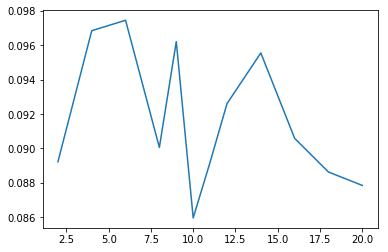

In [9]:
import matplotlib.pyplot as plt
plt.plot(rankList, scores)
plt.show()


Now, using the bestModel, we will check the results over the test data. Your result should be ~`0.0507`.  
Step below takes 1 minute to run. Uncomment last line if you wish to run and calculate model score. 

In [10]:
bestModel = ALS.trainImplicit(trainData, rank=10, seed=345)
modelEval(bestModel, testData)

0.053467354522831995

In [11]:
bestModel2 = ALS.trainImplicit(trainData, rank=6, seed=345)
modelEval(bestModel2, testData)

0.07098262738486256

## Trying Some Artist Recommendations
Using the best model above, predict the top 5 artists for user `1059637` using the [recommendProducts](http://spark.apache.org/docs/1.5.2/api/python/pyspark.mllib.html#pyspark.mllib.recommendation.MatrixFactorizationModel.recommendProducts) function. Map the results (integer IDs) into the real artist name using `artistAlias`. Print the results. The output should look as follows:
```
Artist 0: My Chemical Romance
Artist 1: Something Corporate
Artist 2: Evanescence
Artist 3: Alanis Morissette
Artist 4: Counting Crows
```

In [14]:
# Find the top 5 artists for a particular user and list their names
# YOUR CODE GOES HERE

top5 = []

predictedArtists = bestModel.recommendProducts(1059637, 5)

for item in predictedArtists:
    top5.append(item[1])
    

artistDataMap = artistData.collectAsMap()
    
for i in range(0,5):
    print ("Artist"+str(i)+":"+ artistDataMap[top5[i]])

Artist0:Something Corporate
Artist1:My Chemical Romance
Artist2:Green Day
Artist3:Taking Back Sunday
Artist4:The Used


In [15]:
#predictions with rank 6 i.e. bestModel2

top5 = []

predictedArtists = bestModel2.recommendProducts(1059637, 5)

for item in predictedArtists:
    top5.append(item[1])
    

artistDataMap = artistData.collectAsMap()
    
for i in range(0,5):
    print ("Artist"+str(i)+":"+ artistDataMap[top5[i]])

Artist0:Something Corporate
Artist1:My Chemical Romance
Artist2:Alkaline Trio
Artist3:Maroon 5
Artist4:blink-182
